<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Projeto Proposto 
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Este projeto tem o intuito de estudar Modelos de Séries Temporais para previsão de informações sobre a temperatura na Índia. </i>       
</p>  

https://www.kaggle.com/code/obougacha/a-guide-for-time-series-analysis-arima-sarima#Conclusion-and-discussion

https://www.kaggle.com/code/jurk06/auto-arima-on-multivariate-time-series

https://www.kaggle.com/code/georgyzubkov/daily-climate-in-delhi-arima-with-timeseries

# <font color='red' style='font-size: 40px;'> Problemática </font>
<hr style='border: 2px solid red;'>

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i>  Este projeto tem o intuito de estudar Modelos de Séries Temporais para previsão de informações sobre a temperatura na Índia.


</i> 
</p>  

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> 
</i> 
</p>  


# <font color='red' style='font-size: 40px;'> Bibliotecas Utilizadas </font>
<hr style='border: 2px solid red;'>

In [313]:
## Bibliotecas De Manipulação de Dados e Visualização
import pandas as pd 
import geopandas as gpd
import builtins as builtins
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import plotly.express as px
import plotly.io as pio
from IPython.display import display, Image

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm


# Bibliotecas de Manipulação de Tempo
import time
import datetime

# Bibliotecas de Métricas de Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Parâmetros de Otimização
import warnings
%matplotlib inline
sns.set()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings

# <font color='red' style='font-size: 40px;'> Funções </font>
<hr style='border: 2px solid red;'>

In [199]:
def analisa_estacionaridade(series):
    for test_name, test in {"Adfuller": adfuller, "KPSS": kpss}.items():
        result = test(series.values)
        print(f'\033[34m{test_name}\033[0m')
        print('p-value: %.3f' % result[1]) #posição do p_value é a mesma para ambos testes (posição 1)

        # Os valores críticos estão na posição 4 na saída do Adfuller e na posição 3 do KPSS:
        critical_values = result[4] if test_name == "Adfuller" else result[3]
        critical_values = critical_values["5%"] # Vamos olhar apenas o teste com 95% de confiança

        check_adfuller = (test_name == "Adfuller") & (result[1] <= 0.05)  & (critical_values > result[0])
        check_kpss = (test_name == "KPSS") & (result[1] > 0.05)  & (critical_values > result[0])

        if (check_adfuller) | (check_kpss):
            print("\u001b[32mEstacionária com nível de confiança de 95%\u001b[0m")
        else:
            print("\x1b[31mNão estacionária com nível de confiança de 95%\x1b[0m")
        print("\n")

In [200]:
def plota_acf_pacf(series):
    fig, ax = plt.subplots(2,1, figsize = (12,5))
    fig = sm.graphics.tsa.plot_acf(series, lags=50, ax=ax[0], auto_ylims=True)
    fig = sm.graphics.tsa.plot_pacf(series, lags=50, ax=ax[1], auto_ylims=True)
    plt.tight_layout()
    plt.show()

In [201]:
def plota_histograma_boxplot_qq(variavel, df, titulo):
    mediana = df[variavel].median()
    media = round(df[variavel].mean(), 2)

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Histograma
    sns.histplot(data=df, x=variavel, bins=60, ax=axes[0], color='#1FB3E5', shrink=0.8)
    axes[0].axvline(x=mediana, ymax=0.75, color='#231F20', linestyle='-', label=f'Mediana = {mediana}')
    axes[0].axvline(x=media, ymax=0.75, color='#231F20', linestyle='--', label=f'Média = {media}')
    axes[0].set_title(f'Distribuição {titulo}', fontsize=14)
    axes[0].set_xlabel('Valores', fontsize=12)
    axes[0].set_ylabel('Frequência', fontsize=12)
    axes[0].legend(loc='best')
    axes[0].grid(False)
    axes[0].set_frame_on(False)

    # Boxplot
    sns.boxplot(data=df, x=variavel, ax=axes[1], color='#1FB3E5', orient='h')
    axes[1].set_title(f'Boxplot {titulo}', fontsize=14)
    axes[1].set_xlabel('Valores', fontsize=12)
    axes[1].grid(False)
    axes[1].set_frame_on(False)

    # QQ Plot
    stats.probplot(df[variavel].dropna(), dist="norm", plot=axes[2])
    axes[2].set_title(f'QQ Plot {titulo}', fontsize=14)
    axes[2].grid(False)
    axes[2].set_xlabel('Quantis Teóricos', fontsize=12)
    axes[2].set_ylabel('Quantis da Amostra', fontsize=12)

    plt.tight_layout()
    plt.show()


In [202]:
def ano_mes_dia(df):

    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day


In [203]:
def separa_feature_target(target, dados):
    x = dados.drop(target, axis = 1)
    y = dados[[target]]
    return x, y

In [ ]:
def separa_treino_teste_temporal(data, data_teste, dados):
    dados.sort_values(by = data, ascending = True, inplace = True)
    df_train = dados.loc[dados[data] < data_teste]
    df_test = dados.loc[dados[data] >= data_teste]

    return df_train, df_test

In [253]:
def metricas(modelo, y_true, y_predict):

    mae = mean_absolute_error(y_predict, y_true)
    mse = mean_squared_error(y_predict, y_true)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_predict, y_true)
    metricas = pd.DataFrame(
        {
            'MAE':mae, 
            'RMSE':rmse, 
            'MAPE':mape,
            'modelo':modelo
        }, index = np.arange(1, 2))

    return metricas



# <font color='red' style='font-size: 40px;'> 1) Leitura do Dataset </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 1.1) Descrição das Variáveis </font>
<hr style='border: 2px solid green;'>

### 1.1.1) Cases

1. **Date:** Data

2. **meantemp:** Temperatura média medida por 3 intervalos de tempo no dia

3. **humidty:** Humidade (unidade: gramas de vapor/volume de ar por metro cúbico)

4. **wind_speed:** Velocidade do Vento

5. **meanpressure:** Pressão atmosférica

In [206]:
df_climate_train = pd.read_csv('./data/DailyDelhiClimateTrain.csv')
ano_mes_dia(df_climate_train)
df_climate_train = df_climate_train[['date', 'month', 'year', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']]


df_climate_test = pd.read_csv('./data/DailyDelhiClimateTest.csv')
ano_mes_dia(df_climate_test)
df_climate_test = df_climate_test[['date', 'month', 'year', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']]

# <font color='red' style='font-size: 40px;'> 2) Análise Exploratória </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 2.1) Como é a distribuição das variáveis ? </font>
<hr style='border: 2px solid green;'>

> 1. As distribuições parecem estáveis, de modo que não vemos valores tão extremos que nos levariam a achar que foi um erro

> 2. A Pressão Atmosférica apresenta um caso de valor negativo (está medida em ATM, então é impossível) e há um valor de 7679 que é muito diferente do resto da distribuição, portanto, pode-se considerá-lo um erro de medição

In [207]:
df_climate_train.describe(percentiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

,month,year,meantemp,humidity,wind_speed,meanpressure
count,1462.00,1462.00,1462.00,1462.00,1462.00,1462.00
mean,6.52,2014.50,25.50,60.77,6.80,1011.10
std,3.45,1.12,7.35,16.77,4.56,180.23
min,1.00,2013.00,6.00,13.43,0.00,-3.04
1%,1.00,2013.00,9.95,22.22,0.00,994.20
5%,1.00,2013.00,12.51,29.00,0.93,996.83
10%,2.00,2013.00,14.62,36.21,1.62,998.14
20%,3.00,2013.00,17.62,47.25,2.91,1000.54
30%,4.00,2014.00,21.13,53.24,4.16,1002.74
40%,5.00,2014.00,24.50,58.05,5.18,1005.35


# <font color='green' style='font-size: 30px;'> 2.2) Como se comporta o a temperatura, humidade, velocidade do vento e a pressão atmosférica ao longo do tempo ? </font>
<hr style='border: 2px solid green;'>

> 1. A temperatura e a humidade aparentam sofrer ciclos, sazonalidades e tendências de subida e descida

> 2. A velocidade do vento parece ser um pouco mais estacionária, mas visualmente não é possível ter certeza

> 3. A pressão atmosférica está com o gráfico deturpado devido a presença de Outliers Inferiores e Superiores Extremos, portanto, deveríamos retirá-los para termos compreensao da série histórica

> 4. Retirando os Outliers, a pressão atmosférica parece sofrer ciclos, sazonalidades e tendências de subida e descida, mas o interessante é que ela é inversamento proporcional a temperatura

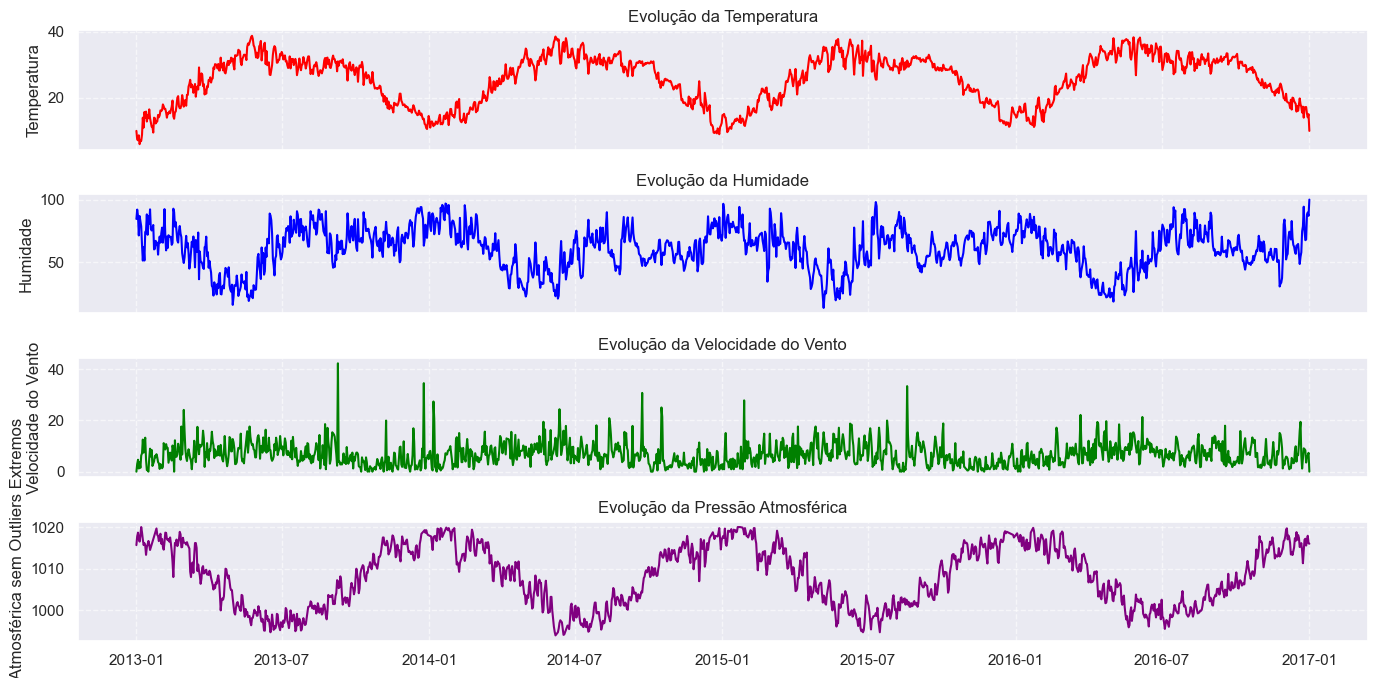

In [208]:
# Criando a figura e os subplots
fig, ax = plt.subplots(4, 1, figsize=(14, 7), sharex=True)  # 4 linhas, 1 coluna

# Gráfico de Temperatura
ax[0].plot(df_climate_train['date'], df_climate_train['meantemp'], linestyle='-', color='red')
ax[0].set_ylabel("Temperatura")
ax[0].set_title("Evolução da Temperatura")
ax[0].grid(True, linestyle="--", alpha=0.6)

# Gráfico de Humidade
ax[1].plot(df_climate_train['date'], df_climate_train['humidity'], linestyle='-', color='blue')
ax[1].set_ylabel("Humidade")
ax[1].set_title("Evolução da Humidade")
ax[1].grid(True, linestyle="--", alpha=0.6)


# Gráfico de Velocidade do Vento
ax[2].plot(df_climate_train['date'], df_climate_train['wind_speed'], linestyle='-', color='green')
ax[2].set_ylabel("Velocidade do Vento")
ax[2].set_title("Evolução da Velocidade do Vento")
ax[2].grid(True, linestyle="--", alpha=0.6)

# Gráfico de Pressão Atmosférica sem Outliers Extremos
ax[3].plot(df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)]['date'], df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)]['meanpressure'], linestyle='-', color='purple')
ax[3].set_ylabel("Pressão Atmosférica sem Outliers Extremos")
ax[3].set_title("Evolução da Pressão Atmosférica")
ax[3].grid(True, linestyle="--", alpha=0.6)


# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()


# <font color='green' style='font-size: 30px;'> 2.3) Como se comportam as componentes temporais da série histórica? </font>
<hr style='border: 2px solid green;'>

> 1. Trataremos as componentes através de um Modelo Aditivo

> 2. Modelos aditivos em séries temporais são um tipo de abordagem utilizada para decompor uma série temporal em componentes distintos que podem ser somados para explicar a variação nos dados ao longo do tempo. Esses componentes tipicamente incluem:

- Tendência (Trend): Representa a direção geral dos dados ao longo do tempo (por exemplo, uma tendência crescente ou decrescente).

- Sazonalidade (Seasonality): Captura padrões repetitivos que ocorrem em intervalos regulares (por exemplo, variações sazonais mensais ou anuais).

- Ciclo (Cycle): Refere-se a flutuações de longo prazo que não são devidas a sazonalidade (por exemplo, ciclos econômicos).

- Ruído (Noise): Componentes aleatórios ou erros que não são explicados pelos outros componentes.

## $$ Y_{t} = S_{t} + T{t} + R{t} $$ 

> 3. Podemos testar estacionaridade usando o Teste KPSS e o Dickey-Fuller

No KPSS o teste de hipótese se resume a:

<center>

| Nome do teste | $H_0$ (p-value > 0.05) |  $H_1$ (p-value <= 0.05) |
|---------------|------------------------|--------------------------|
| KPSS | É estacionária | Não é estacionária |

</center>

- O [teste KPSS](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html) (Kwiatkowski-Phillips-Schmidt-Shin) compara a série temporal com um modelo estacionário que tem características semelhantes à série. Ele avalia a diferença entre a série real e o modelo estacionário para determinar se a série é estacionária ou não.

- H0: É estacionário --> Não rejeitada caso p-value > 0.05

- H1: Não é estacionário --> Rejeição de H0 caso p-value <= 0.05

No ADF o teste de hipótese se resume a:

<center>

| Nome do teste | $H_0$ (p-value > 0.05) |  $H_1$ (p-value <= 0.05) |
|---------------|------------------------|--------------------------|
| ADF | Não é estacionária | É estacionária |

</center>

- O [teste de Dickey-Fuller Aumentado](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) é um teste estatístico utilizado para verificar a presença de raiz unitária em uma série temporal. Uma série temporal é considerada ter uma raiz unitária se ela não for estacionária, ou seja, se sua média e variância não forem constantes ao longo do tempo. Essa verificação acontece comparando a série temporal original com uma versão diferenciada da mesma. Ele compara a série temporal original com uma versão diferenciada da série. A diferenciação envolve subtrair cada valor da série pelo valor anterior, o que pode ajudar a remover tendências ou padrões de longo prazo na série. 

- H0: Não é estacionário --> Não rejeitada caso p-value > 0.05

- H1: É estacionário --> Rejeição de H0 caso p-value <= 0.05


> 4. Pela análise gráfica, nota-se que nenhuma das séries é estacionária, mesmo que o Teste de Hipótese afirme que sim

- Temperatura

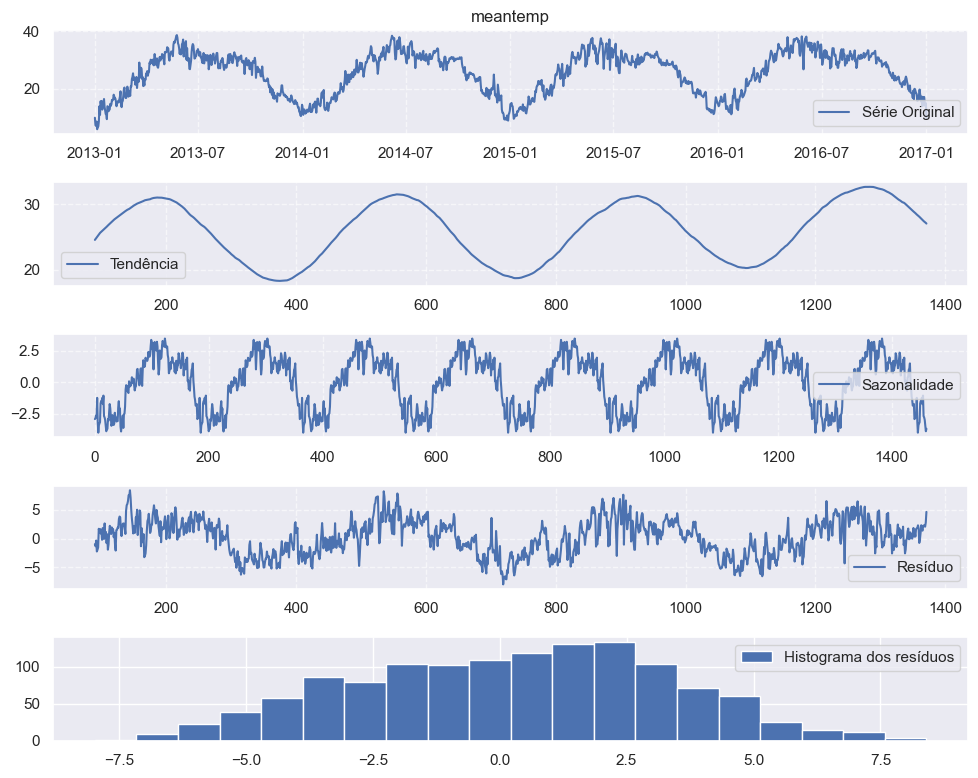

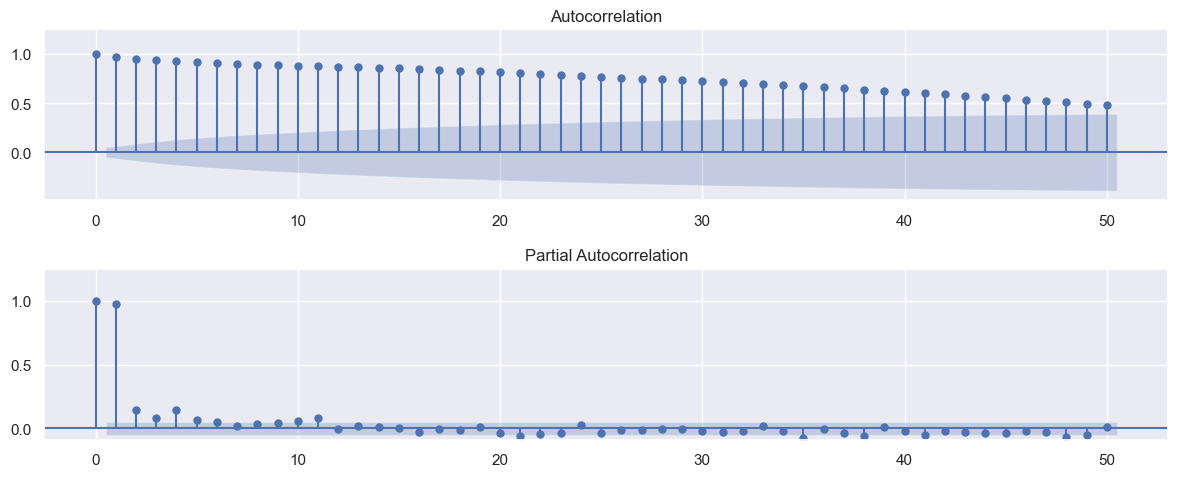

Adfuller
p-value: 0.277
Não estacionária com nível de confiança de 95%


KPSS
p-value: 0.100
Estacionária com nível de confiança de 95%




In [209]:
# Realizar a decomposição da série temporal
result = seasonal_decompose(df_climate_train['meantemp'], model='additive', period=180)

# o primeiro número (5) representa o número total de linhas, e o segundo número (5) representa o índice do subplot dentro da grade. 

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))

plt.subplot(511)
plt.plot(df_climate_train['date'], df_climate_train['meantemp'], label='Série Original')
plt.title('meantemp')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(512)
plt.plot(result.trend, label='Tendência')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(513)
plt.plot(result.seasonal,label='Sazonalidade')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(514)
plt.plot(result.resid, label='Resíduo')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(515)
plt.hist(result.resid, bins=20, label="Histograma dos resíduos")
plt.legend()

plt.tight_layout()
plt.show()

plota_acf_pacf(df_climate_train['meantemp'])

analisa_estacionaridade(df_climate_train['meantemp'])


- Humidade

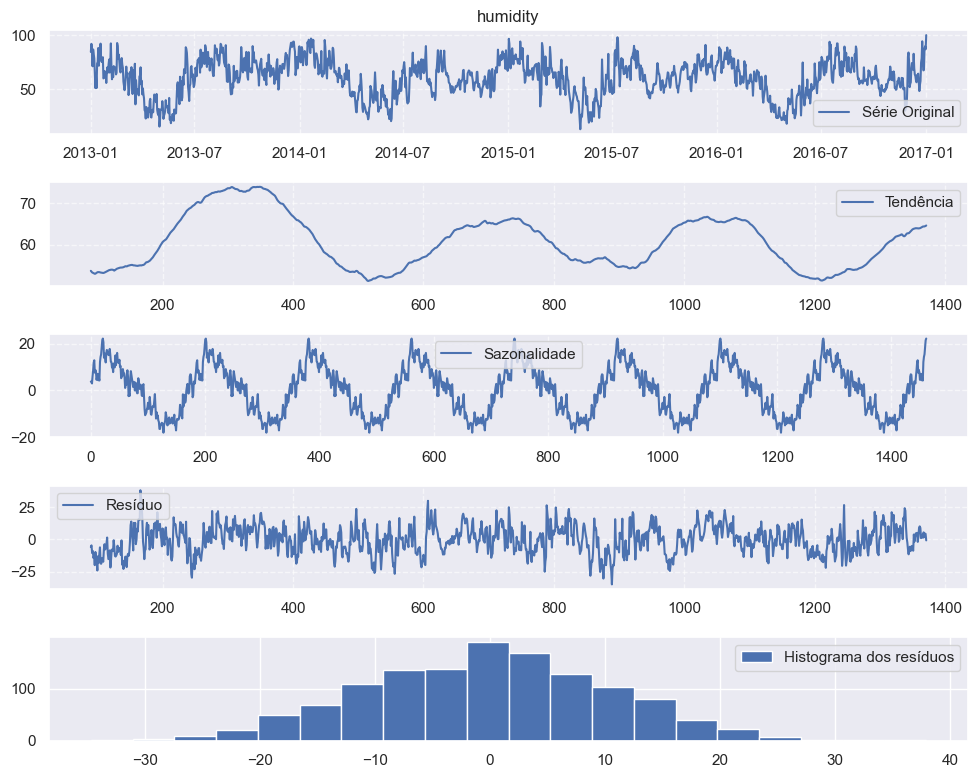

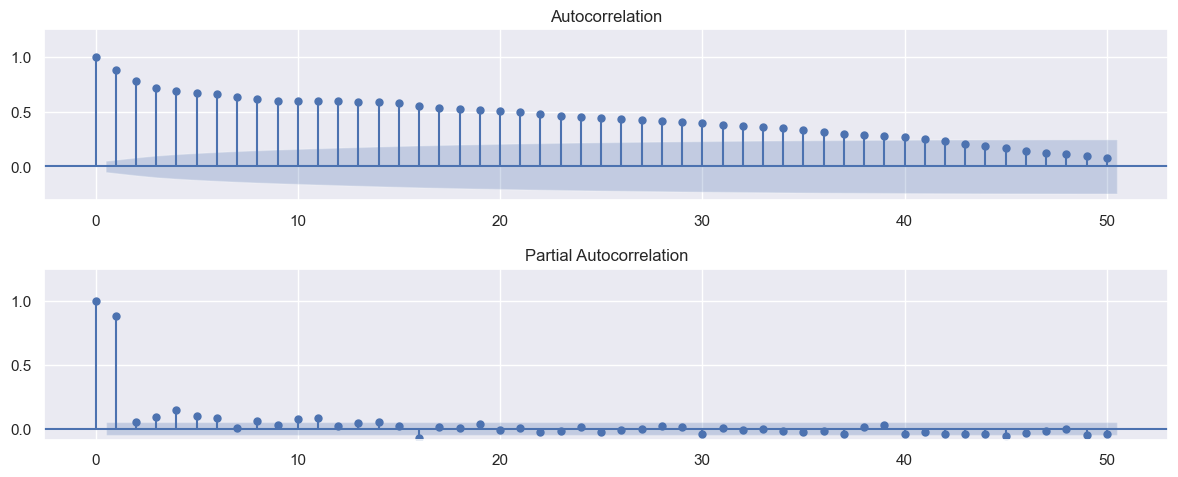

Adfuller
p-value: 0.004
Estacionária com nível de confiança de 95%


KPSS
p-value: 0.100
Estacionária com nível de confiança de 95%




In [210]:
# Realizar a decomposição da série temporal
result = seasonal_decompose(df_climate_train['humidity'], model='additive', period=180)

# o primeiro número (5) representa o número total de linhas, e o segundo número (5) representa o índice do subplot dentro da grade. 

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))

plt.subplot(511)
plt.plot(df_climate_train['date'], df_climate_train['humidity'], label='Série Original')
plt.title('humidity')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(512)
plt.plot(result.trend, label='Tendência')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(513)
plt.plot(result.seasonal,label='Sazonalidade')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(514)
plt.plot(result.resid, label='Resíduo')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(515)
plt.hist(result.resid, bins=20, label="Histograma dos resíduos")
plt.legend()

plt.tight_layout()
plt.show()

plota_acf_pacf(df_climate_train['humidity'])

analisa_estacionaridade(df_climate_train['humidity'])


- Velocidade do Vento

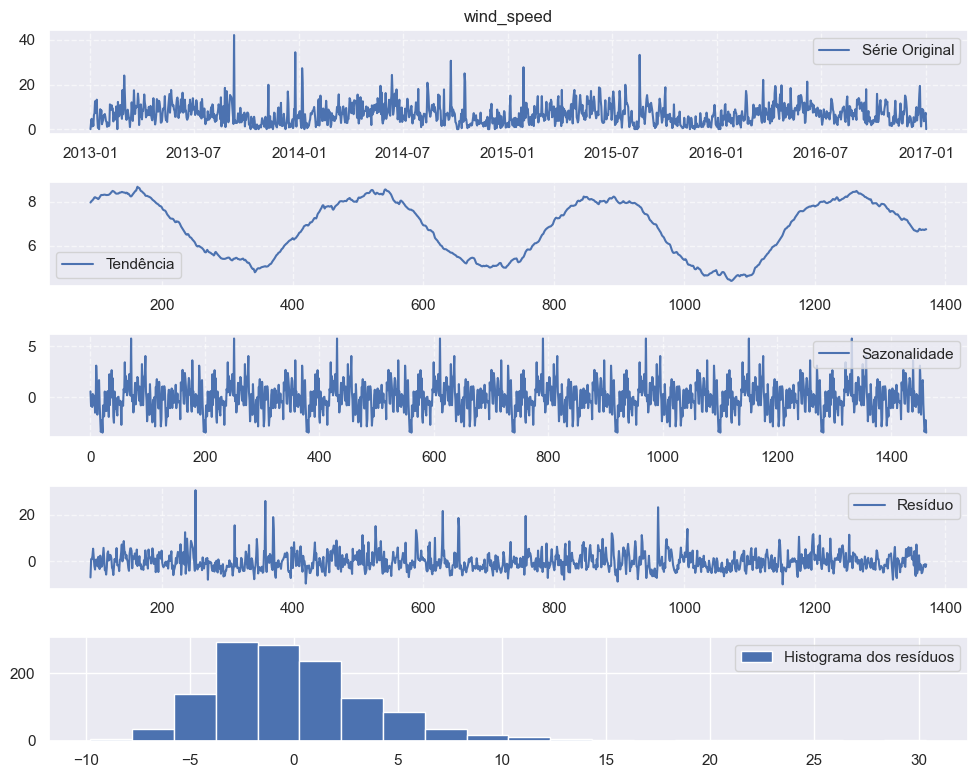

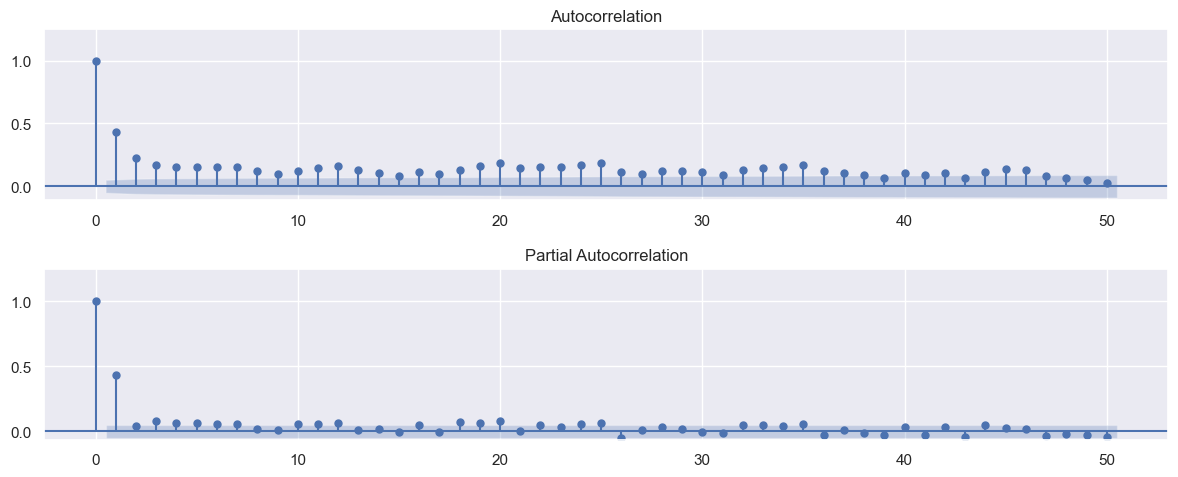

Adfuller
p-value: 0.003
Estacionária com nível de confiança de 95%


KPSS
p-value: 0.100
Estacionária com nível de confiança de 95%




In [211]:
# Realizar a decomposição da série temporal
result = seasonal_decompose(df_climate_train['wind_speed'], model='additive', period=180)

# o primeiro número (5) representa o número total de linhas, e o segundo número (5) representa o índice do subplot dentro da grade. 

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))

plt.subplot(511)
plt.plot(df_climate_train['date'], df_climate_train['wind_speed'], label='Série Original')
plt.title('wind_speed')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(512)
plt.plot(result.trend, label='Tendência')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(513)
plt.plot(result.seasonal,label='Sazonalidade')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(514)
plt.plot(result.resid, label='Resíduo')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(515)
plt.hist(result.resid, bins=20, label="Histograma dos resíduos")
plt.legend()

plt.tight_layout()
plt.show()

plota_acf_pacf(df_climate_train['wind_speed'])

analisa_estacionaridade(df_climate_train['wind_speed'])


- Pressão Atmosférica

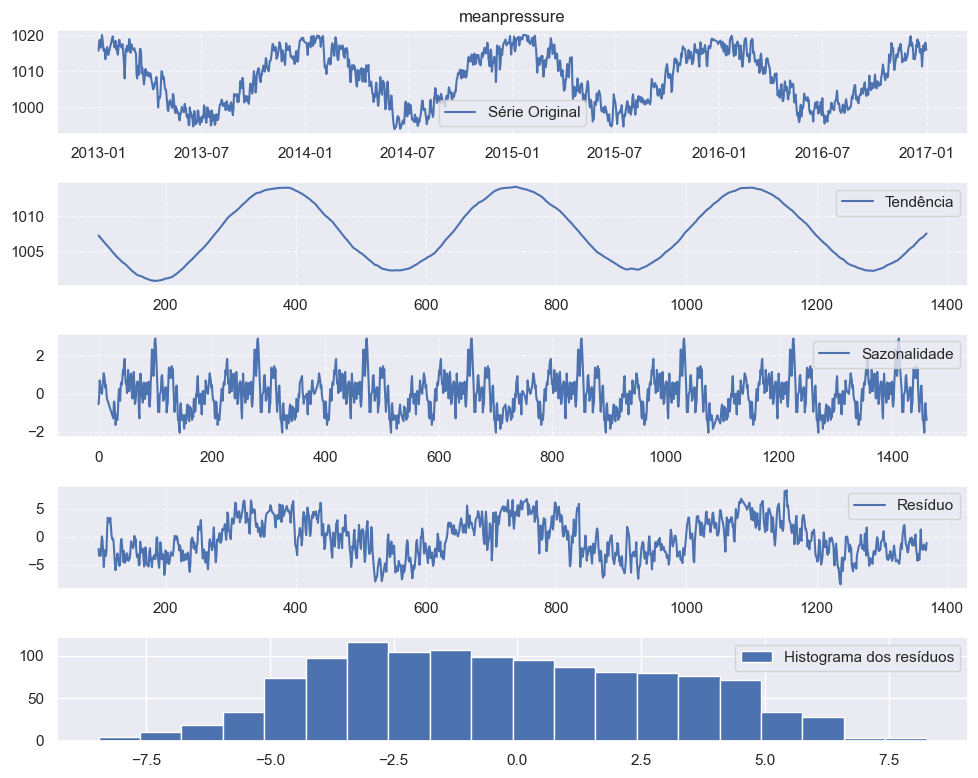

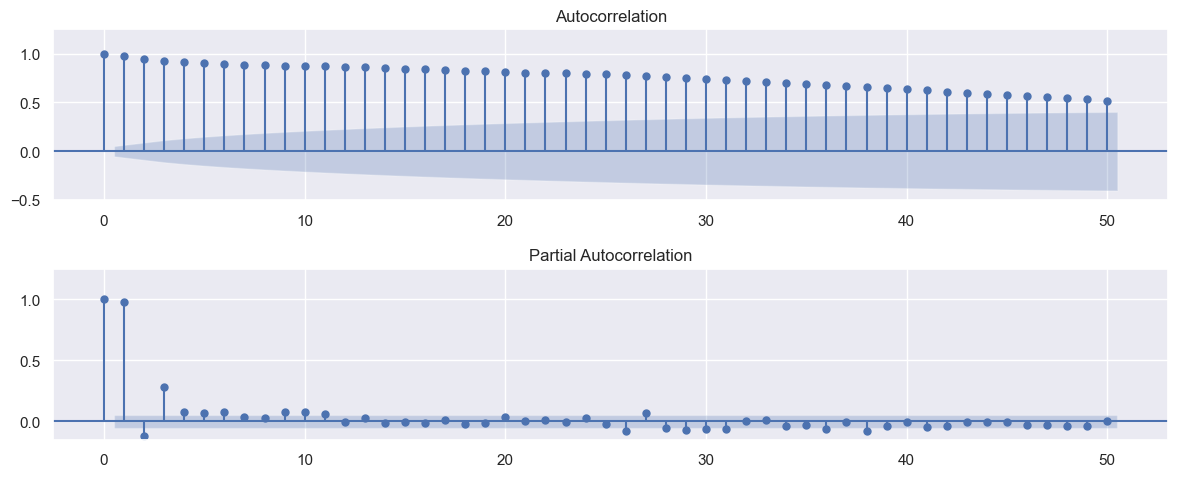

Adfuller
p-value: 0.244
Não estacionária com nível de confiança de 95%


KPSS
p-value: 0.100
Estacionária com nível de confiança de 95%




In [212]:
# Realizar a decomposição da série temporal
result = seasonal_decompose(df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)]['meanpressure'], model='additive', period=180)

# o primeiro número (5) representa o número total de linhas, e o segundo número (5) representa o índice do subplot dentro da grade. 

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))

plt.subplot(511)
plt.plot(df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)]['date'], df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)]['meanpressure'], label='Série Original')
plt.title('meanpressure')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(512)
plt.plot(result.trend, label='Tendência')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(513)
plt.plot(result.seasonal,label='Sazonalidade')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(514)
plt.plot(result.resid, label='Resíduo')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(515)
plt.hist(result.resid, bins=20, label="Histograma dos resíduos")
plt.legend()

plt.tight_layout()
plt.show()

plota_acf_pacf(df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)]['meanpressure'])

analisa_estacionaridade(df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)]['meanpressure'])


# <font color='green' style='font-size: 30px;'> 2.4) Como são as distribuições das séries? </font>
<hr style='border: 2px solid green;'>

> 1. As séries não aparentam ser Distribuições Normais, ou seja, aparentemente a variância pode ser elevada e ser caótica, mostrando alta volatilidade.

> 2. Mensalmente ocorrem picos e vales, mostrando novamente que existem sazonalidades

> 3. Para corrigir isso, podemos aplicar uma Média Móvel, pois a aplicação de médias Móveis permite que a série se torne menos volátil a variações pontuais

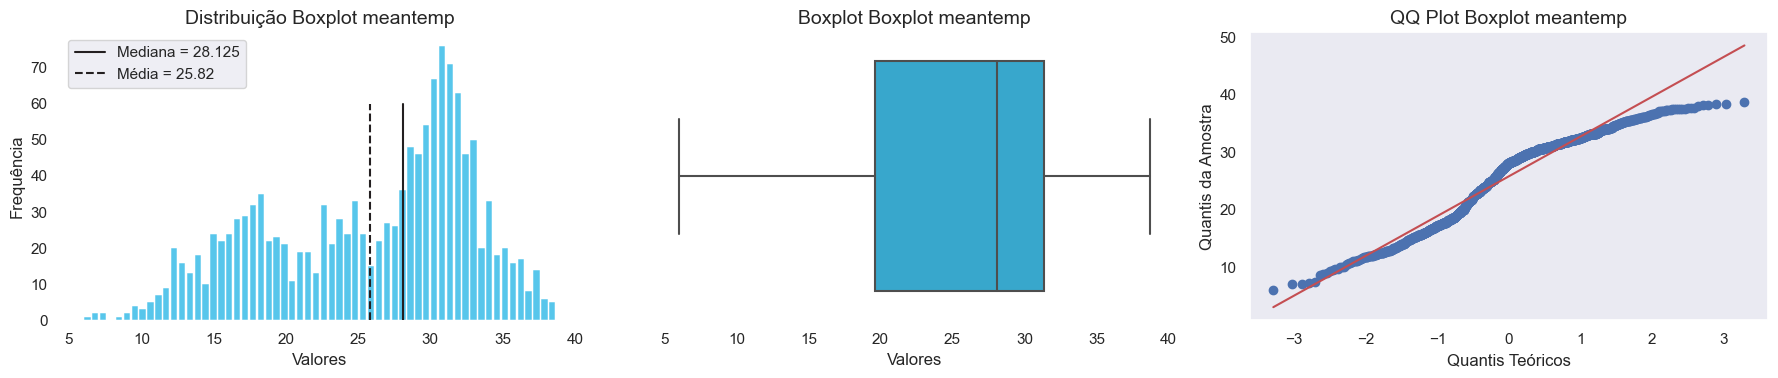

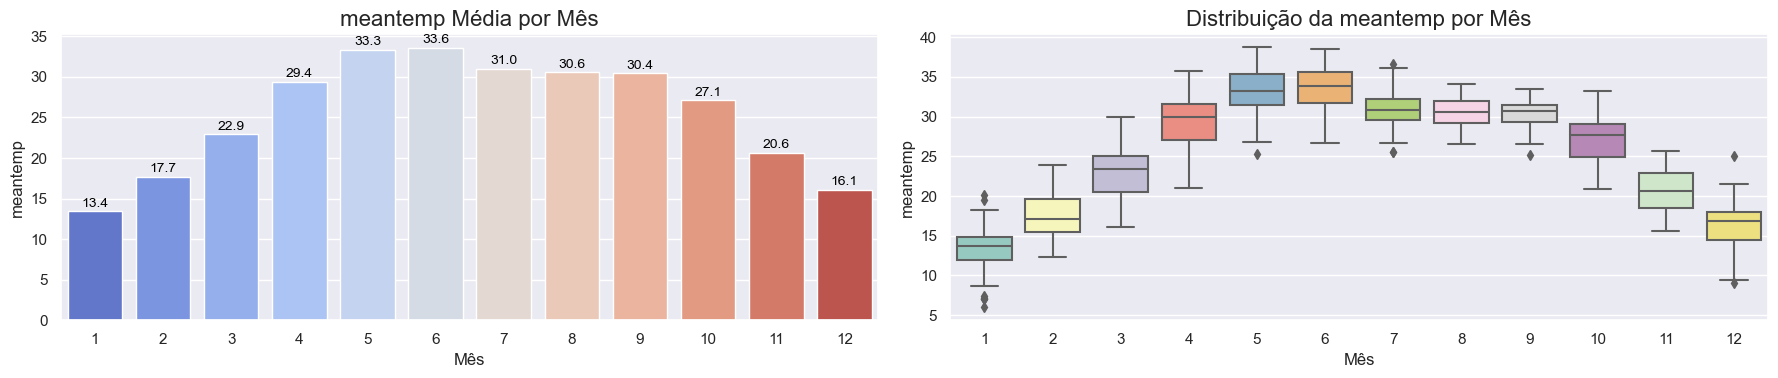

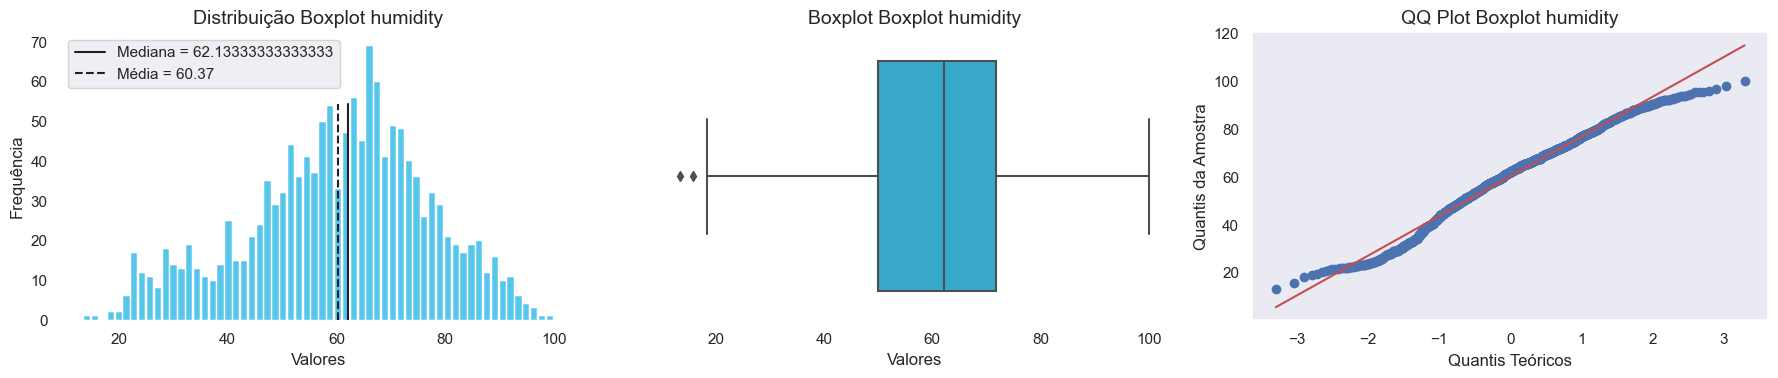

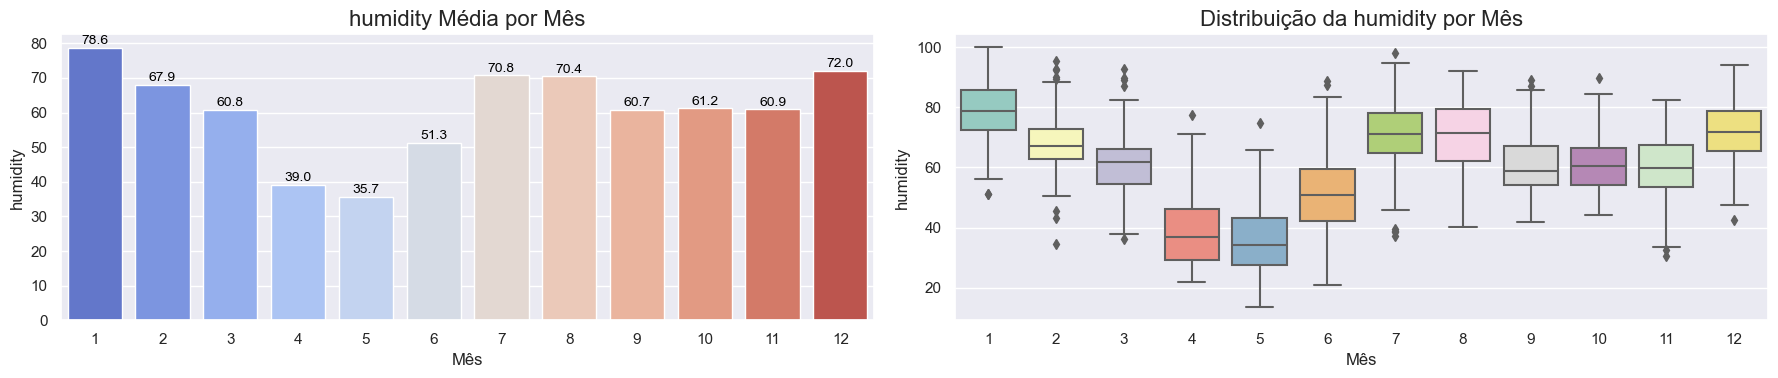

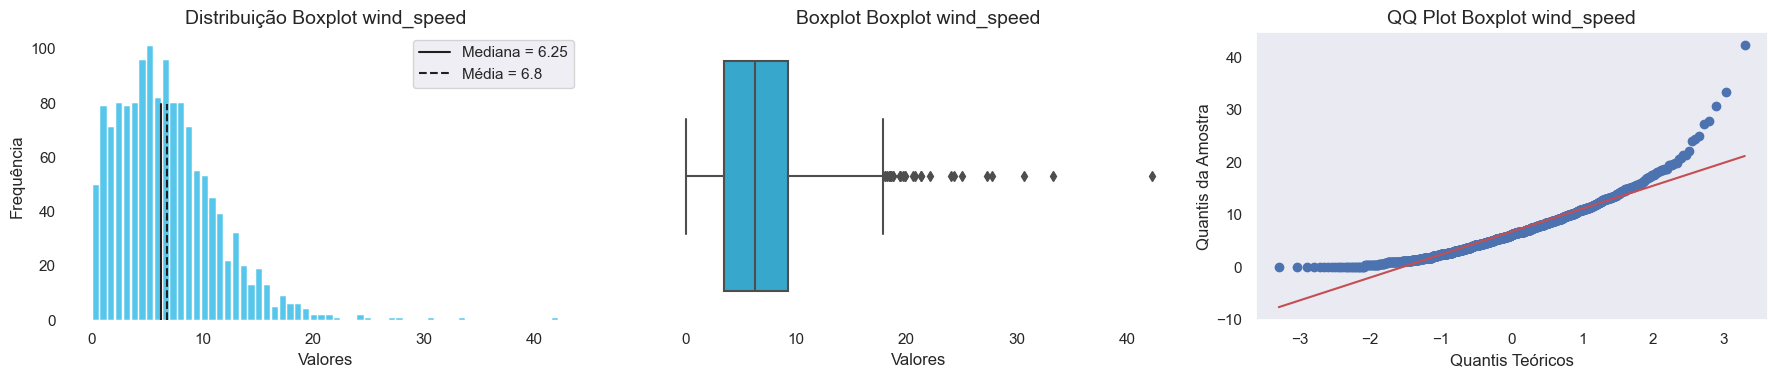

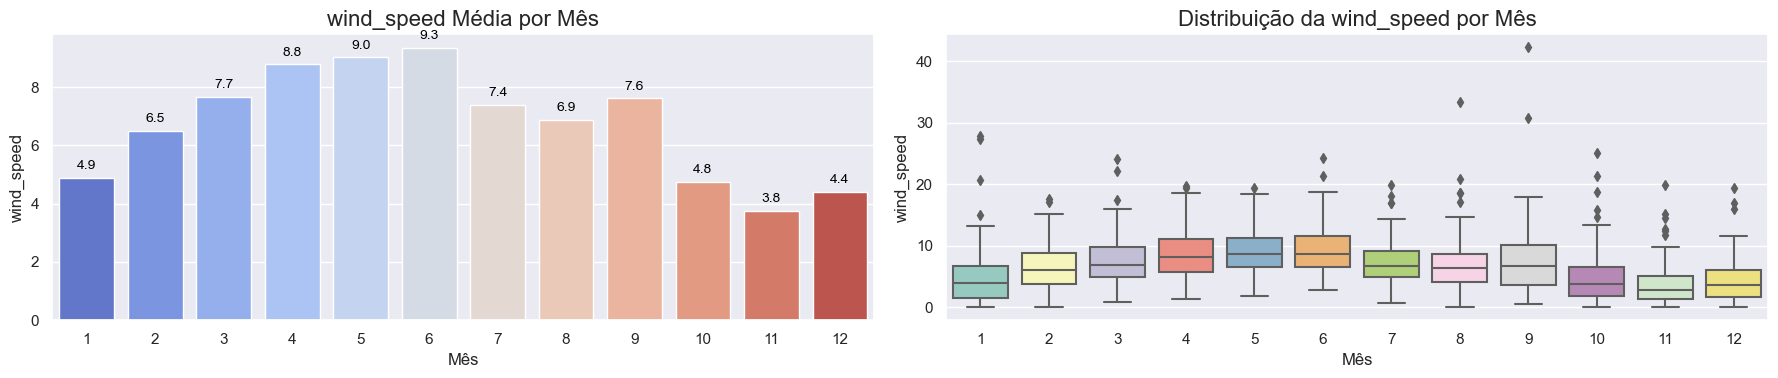

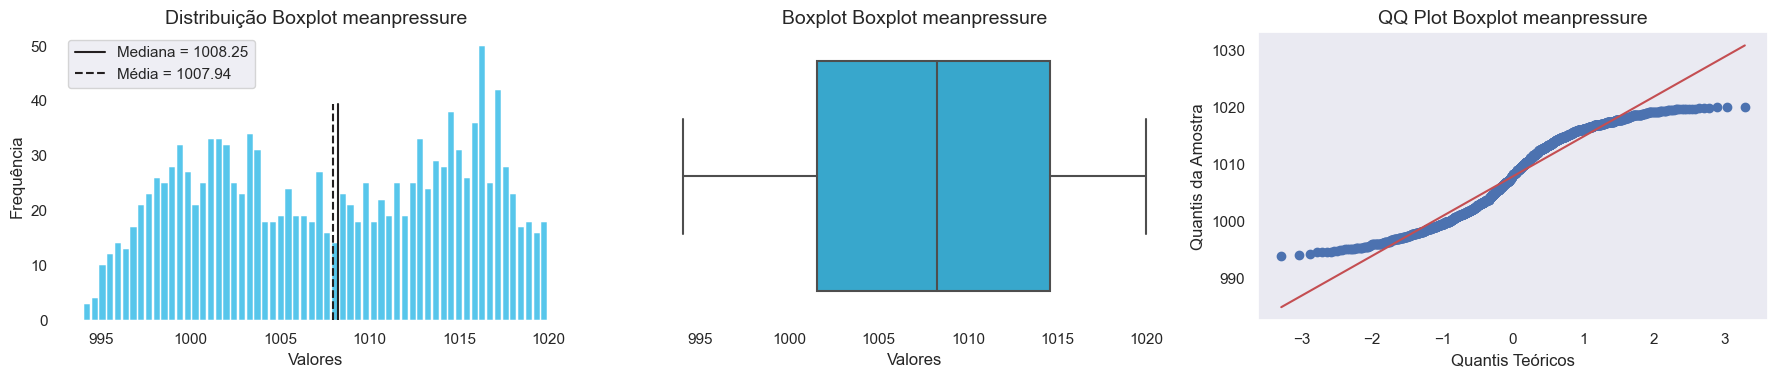

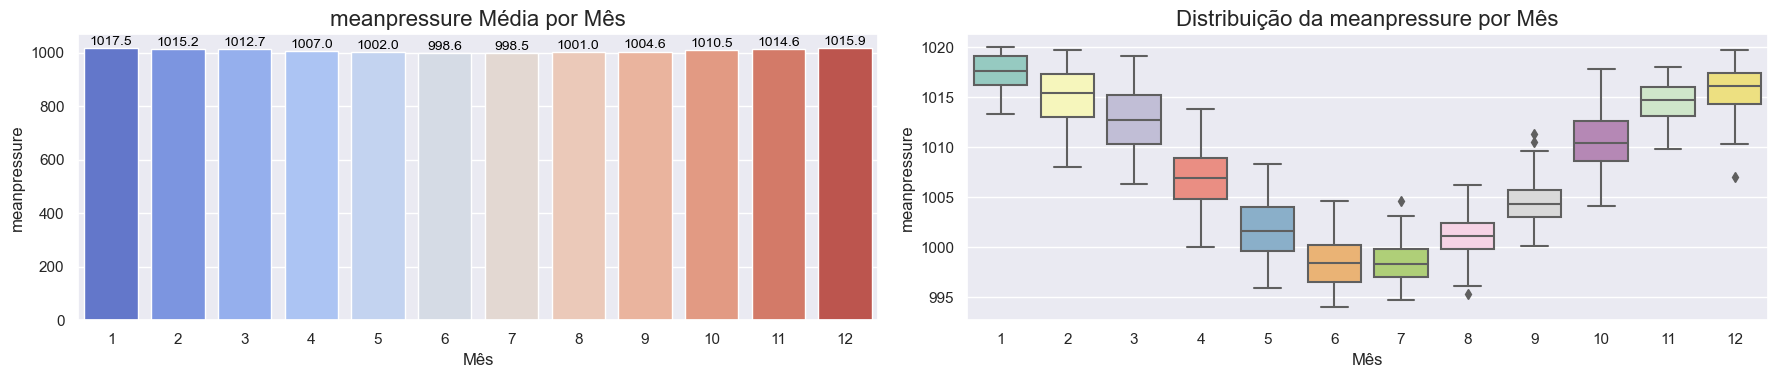

In [213]:
for col in list(df_climate_train.columns)[3:]:
    if col == 'meanpressure':
        plota_histograma_boxplot_qq(col, df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)], f'Boxplot {col}')
        monthly_avg = df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)].groupby('month')[col].mean().reset_index()
        # Criar os subplots
        fig, axes = plt.subplots(1, 2, figsize=(18, 4))

        # Gráfico 1: Média por Mês
        sns.barplot(
            data=monthly_avg,
            x='month',
            y=col,
            palette='coolwarm',
            ax=axes[0]  #
        )
        axes[0].set_title(f'{col} Média por Mês', fontsize=16)
        axes[0].set_xlabel('Mês', fontsize=12)
        axes[0].set_ylabel(f'{col}', fontsize=12)

        for index, row in monthly_avg.iterrows():
            axes[0].text(row.name, row[col] + 0.2, f"{row[col]:.1f}", 
                        ha='center', va='bottom', fontsize=10, color='black')

        # Gráfico 2: Distribuição por Mês (Boxplot)
        sns.boxplot(
            data=df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)],
            x='month',
            y=col,
            palette='Set3',
            ax=axes[1]  #
        )
        axes[1].set_title(f'Distribuição da {col} por Mês', fontsize=16)
        axes[1].set_xlabel('Mês', fontsize=12)
        axes[1].set_ylabel(f'{col}', fontsize=12)

        # Layout final
        plt.tight_layout()
        plt.show()

    else:

        plota_histograma_boxplot_qq(col, df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)], f'Boxplot {col}')
        monthly_avg = df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)].groupby('month')[col].mean().reset_index()
        # Criar os subplots
        fig, axes = plt.subplots(1, 2, figsize=(18, 4))

        # Gráfico 1: Média por Mês
        sns.barplot(
            data=monthly_avg,
            x='month',
            y=col,
            palette='coolwarm',
            ax=axes[0]  #
        )
        axes[0].set_title(f'{col} Média por Mês', fontsize=16)
        axes[0].set_xlabel('Mês', fontsize=12)
        axes[0].set_ylabel(f'{col}', fontsize=12)

        for index, row in monthly_avg.iterrows():
            axes[0].text(row.name, row[col] + 0.2, f"{row[col]:.1f}", 
                        ha='center', va='bottom', fontsize=10, color='black')

        # Gráfico 2: Distribuição por Mês (Boxplot)
        sns.boxplot(
            data=df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)],
            x='month',
            y=col,
            palette='Set3',
            ax=axes[1]  #
        )
        axes[1].set_title(f'Distribuição da {col} por Mês', fontsize=16)
        axes[1].set_xlabel('Mês', fontsize=12)
        axes[1].set_ylabel(f'{col}', fontsize=12)

        # Layout final
        plt.tight_layout()
        plt.show()

# <font color='green' style='font-size: 30px;'> 2.5) Existe correlação entre as séries? </font>
<hr style='border: 2px solid green;'>

> 1. Existem correlações entre as séries, mesmo que fracas

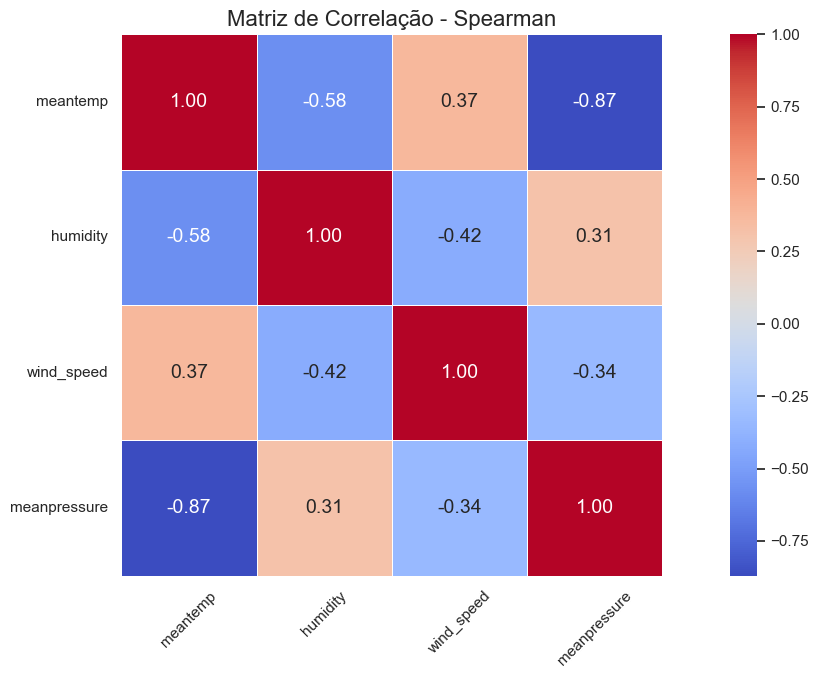

In [214]:
df_climate_train_corr = df_climate_train.drop(['month', 'year'], axis = 1).copy()
plt.figure(figsize=(14, 7))

sns.heatmap(
    df_climate_train_corr.corr(method = 'spearman'),
    annot=True,     
    cmap='coolwarm',
    fmt=".2f",      
    linewidths=0.5, 
    square=True     
)

plt.title("Matriz de Correlação - Spearman", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# <font color='red' style='font-size: 40px;'> 3) Feature Engineering </font>
<hr style='border: 2px solid red;'>

> 1. As Janelas foram escolhidas de acordo com a Diagrama ACF e PACF:

- Para as Lags, observou-se o PACF e viu-se que a Lag 1 era a mais importante, ao passo que o ACF mostrava relação com até a Lag 8

- Dessa forma, optou-se por trabalhar com Janelas de 3 dias, não se distanciando da Lag 1 do PACF e não se alogando tanto até a Lag 8 do ACF

> 2. Pelo gráfico de correlação, decidiu-se testar a presença das variáveis Humidty e Mean Preassure no formato de Média Móvel dos últimos 3 dias

> 3. Para modelos de árvore, a variável do mês é importante para entendimento da sazonalidade

> 4. Para o ARIMA, é importante utilizar a série diferenciada

In [215]:
df_climate_train['month'] = df_climate_train['date'].dt.month

df_climate_train['meantemp_lag_d1'] = df_climate_train['meantemp'].shift(1)
df_climate_train['meantemp_lag_d2'] = df_climate_train['meantemp'].shift(2)
df_climate_train['meantemp_lag_d3'] = df_climate_train['meantemp'].shift(3)

df_climate_train['meantemp_media_movel_d3'] = df_climate_train['meantemp'].shift(1).rolling(3).mean()
df_climate_train['humidity_media_movel_d3'] = df_climate_train['humidity'].shift(1).rolling(3).mean()
df_climate_train['meanpressure_media_movel_d3'] = df_climate_train['meanpressure'].shift(1).rolling(3).mean()

df_climate_train['meantemp_diff1'] = df_climate_train['meantemp'].diff()
df_climate_train['meantemp_diff2'] = df_climate_train['meantemp'].diff().diff()
df_climate_train['meantemp_diff3'] = df_climate_train['meantemp'].diff().diff().diff()

# <font color='red' style='font-size: 40px;'> 4) Modelagem </font>
<hr style='border: 2px solid red;'>

### Testar:

> 1. ARIMA

> 2. SARIMA

> 3. Random Forest

> 4. LightGBM


In [247]:
df_train, df_valid = separa_treino_teste_temporal('date', '2016-03-15', df_climate_train)
df_train.dropna(inplace = True)
df_valid.dropna(inplace = True)

display(df_train.head())
display(df_valid.head())
display(df_climate_test.head())


,date,month,year,meantemp,humidity,wind_speed,meanpressure,meantemp_lag_d1,meantemp_lag_d2,meantemp_lag_d3,meantemp_media_movel_d3,humidity_media_movel_d3,meanpressure_media_movel_d3,meantemp_diff1,meantemp_diff2,meantemp_diff3
3,2013-01-04,1,2013,8.67,71.33,1.23,1017.17,7.17,7.40,10.00,8.19,87.83,1017.38,1.50,1.73,-0.63
4,2013-01-05,1,2013,6.00,86.83,3.70,1016.50,8.67,7.17,7.40,7.74,83.44,1017.88,-2.67,-4.17,-5.90
5,2013-01-06,1,2013,7.00,82.80,1.48,1018.00,6.00,8.67,7.17,7.28,81.72,1017.44,1.00,3.67,7.83
6,2013-01-07,1,2013,7.00,78.60,6.30,1020.00,7.00,6.00,8.67,7.22,80.32,1017.22,0.00,-1.00,-4.67
7,2013-01-08,1,2013,8.86,63.71,7.14,1018.71,7.00,7.00,6.00,6.67,82.74,1018.17,1.86,1.86,2.86


,date,month,year,meantemp,humidity,wind_speed,meanpressure,meantemp_lag_d1,meantemp_lag_d2,meantemp_lag_d3,meantemp_media_movel_d3,humidity_media_movel_d3,meanpressure_media_movel_d3,meantemp_diff1,meantemp_diff2,meantemp_diff3
1169,2016-03-15,3,2016,24.07,58.93,8.65,1014.87,22.38,24.25,24.56,23.73,66.04,1011.69,1.69,3.57,5.13
1170,2016-03-16,3,2016,23.94,53.75,10.88,1012.81,24.07,22.38,24.25,23.56,63.37,1013.46,-0.13,-1.82,-5.39
1171,2016-03-17,3,2016,26.31,50.31,6.84,1010.44,23.94,24.07,22.38,23.46,59.56,1014.00,2.38,2.50,4.32
1172,2016-03-18,3,2016,26.19,61.25,6.71,1009.81,26.31,23.94,24.07,24.77,54.33,1012.71,-0.12,-2.50,-5.00
1173,2016-03-19,3,2016,26.79,61.86,3.58,1009.21,26.19,26.31,23.94,25.48,55.10,1011.02,0.60,0.72,3.22


,date,month,year,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,1,2017,15.91,85.87,2.74,59.00
1,2017-01-02,1,2017,18.50,77.22,2.89,1018.28
2,2017-01-03,1,2017,17.11,81.89,4.02,1018.33
3,2017-01-04,1,2017,18.70,70.05,4.54,1015.70
4,2017-01-05,1,2017,18.39,74.94,3.30,1014.33


# <font color='green' style='font-size: 30px;'> 4.1) ARIMA </font>
<hr style='border: 2px solid green;'>

> 1. O ARIMA necessita de uma série estacionária, bem como a estimação das ordens AR, I e MA do Modelo 

- I =1 --> Diferenciação
- AR e MA = 1 mensurados após a Diferenciação

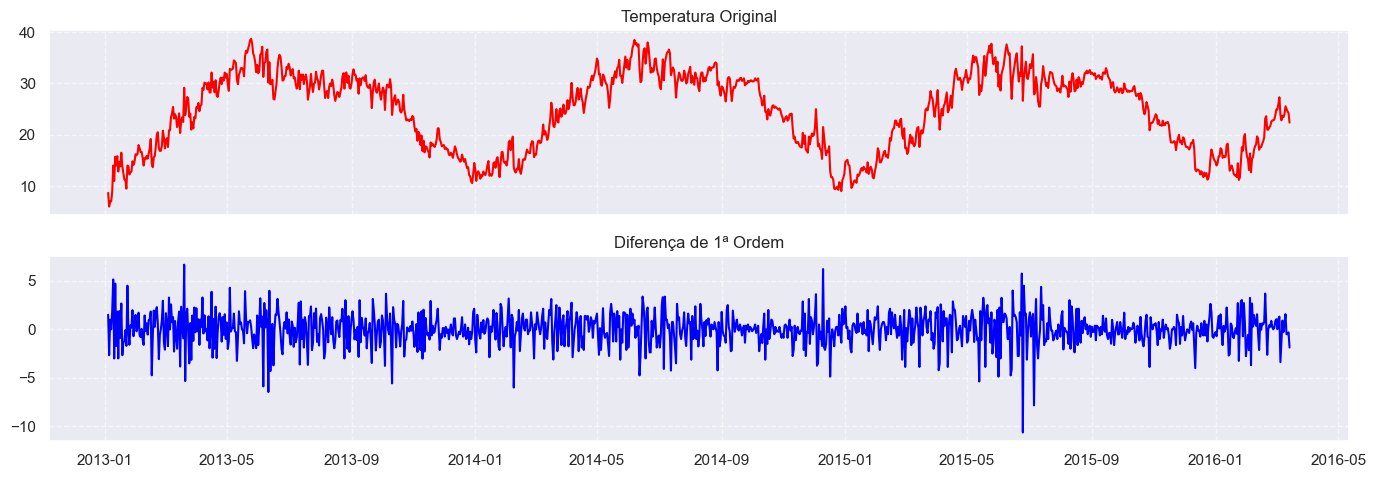

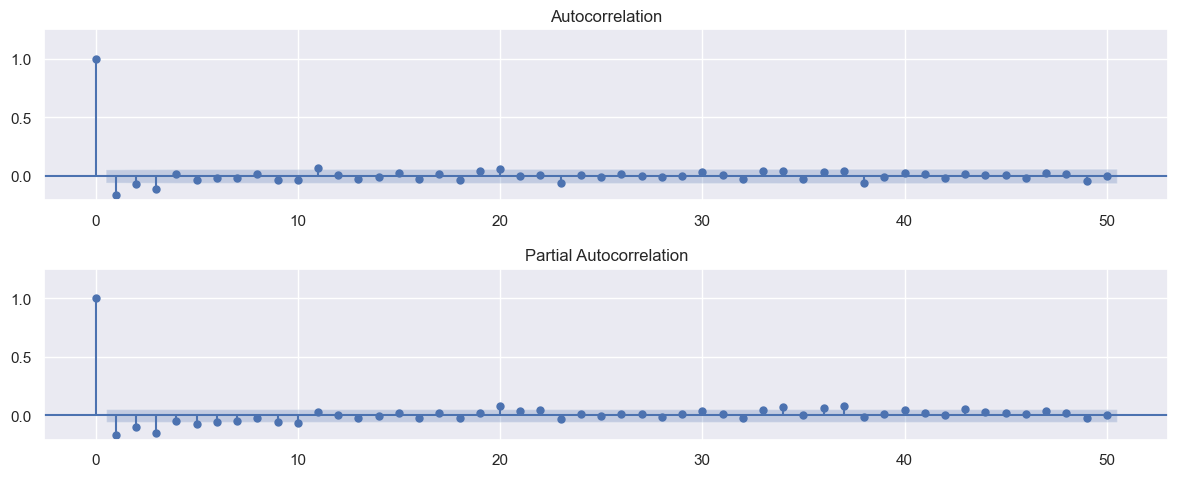

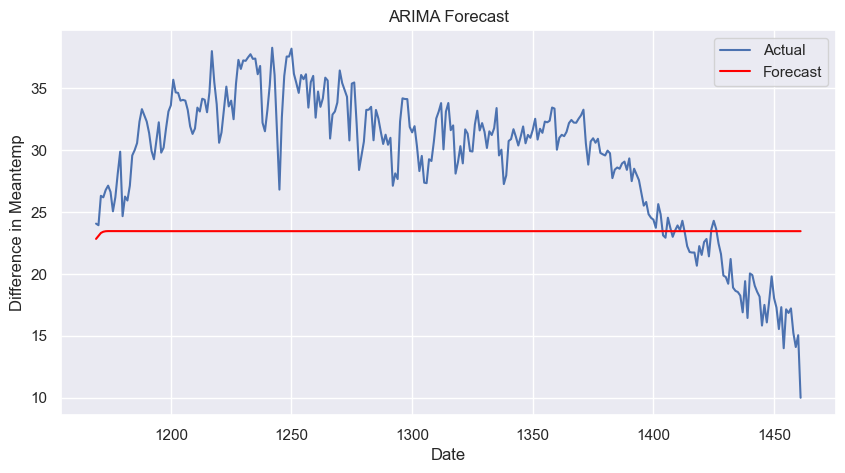

,MAE,RMSE,MAPE,modelo
1,7.26,8.09,0.31,ARIMA


In [267]:
# Define as Ordens do ARIMA
fig, axs = plt.subplots(2, 1, figsize=(14, 5), sharex=True)

axs[0].plot(df_train['date'], df_train['meantemp'], color='red')
axs[0].set_title("Temperatura Original")
axs[0].grid(True, linestyle='--', alpha=0.6)

axs[1].plot(df_train['date'], df_train['meantemp_diff1'], color='blue')
axs[1].set_title("Diferença de 1ª Ordem")
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

plota_acf_pacf(df_train['meantemp_diff1'])

# Fita o ARIMA
arima_model = ARIMA(df_train['meantemp'], order=(3,1,1))  # ARIMA(p,d,q)
arima_model_fit = arima_model.fit()

# Predição
arima_pred = arima_model_fit.forecast(steps=len(df_valid))

# Plot the results
plt.plot(df_valid.index, df_valid['meantemp'], label='Actual')
plt.plot(df_valid.index, arima_pred, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Difference in Meantemp')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# Métricas de Erro
metricas('ARIMA', df_valid['meantemp'], arima_pred)

# <font color='green' style='font-size: 30px;'> 4.2) SARIMA </font>
<hr style='border: 2px solid green;'>

> 1. Consegue trabalhar com Sazonalidades 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=4501.132, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=4472.735, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=4462.517, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=4499.190, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=4461.336, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=4462.513, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=4464.512, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=4422.599, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[4] intercept   : AIC=4422.987, Time=0.22 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=4423.046, Time=0.32 sec
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=4419.671, Time=1.02 sec
 ARIMA(1,1,1)(2,0,1)[4] intercept   : AIC=4421.614, Time=1.86 sec
 ARIMA(1,1,1)(1,0,2)[4] intercept   : AIC=4421.612, Time=1.73 sec
 ARIMA(1,1,1)(0,0,2)[4] intercept   : 

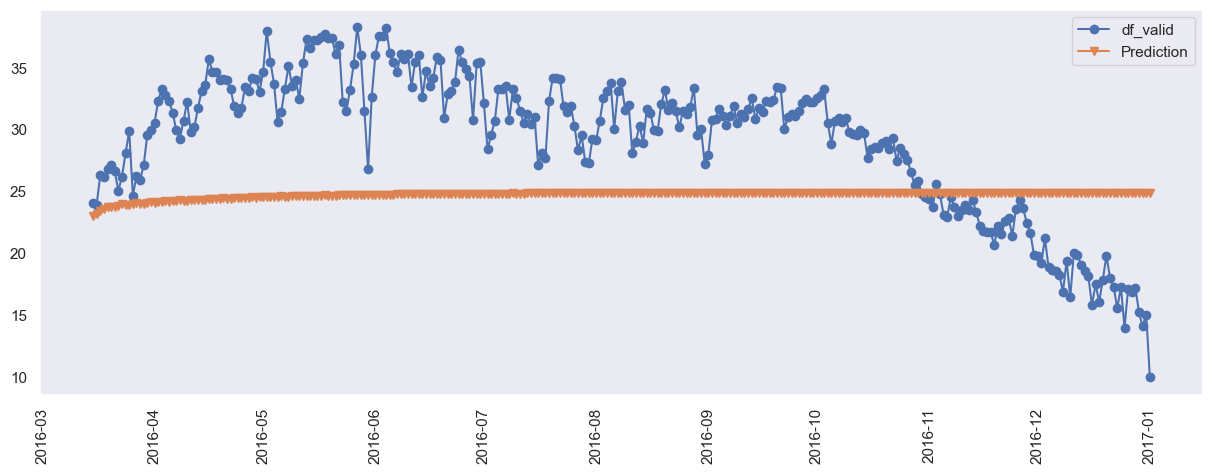

AIC values 4417.981606146239


,Test,Prediction,Difference,% Chnage
0,24.07,22.99,1.08,4.48
1,23.94,23.21,0.72,3.02
2,26.31,23.42,2.90,11.00
3,26.19,23.55,2.63,10.06
4,26.79,23.75,3.03,11.32
...,...,...,...,...
288,17.22,24.89,-7.68,44.58
289,15.24,24.89,-9.65,63.36
290,14.10,24.89,-10.80,76.60
291,15.05,24.89,-9.84,65.37


In [303]:
# Model Evaluation 

# Fit a simple auto_arima model
arima = auto_arima(
    df_train['meantemp'],
    #X=df_train.drop(columns=['date','meantemp']), 
    X = None,
    #d=2,
    error_action='ignore', 
    trace=True,
    suppress_warnings=True, 
    maxiter=500,
    m=4,
    stationary=False,
    test='adf')

# Print out summary information on the fit
print(arima.summary())
print(arima.params)

arima_pred=arima.predict(n_periods=len(df_valid), X=df_valid.drop(columns=['date','meantemp']), alpha=0.05)

plt.figure(figsize=(15,5))
plt.grid()
plt.plot(df_valid['date'],df_valid['meantemp'], marker='o', label='df_valid')
plt.plot(df_valid['date'],arima_pred, marker='v', label='Prediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()

metricas('ARIMA', df_valid['meantemp'], arima_pred)
print("AIC values {}".format(arima.aic()))

a=pd.DataFrame(df_valid['meantemp'])
a=a.reset_index()
a=a.drop(columns='index')
a

prediction=pd.DataFrame(arima_pred)
prediction=prediction.reset_index()
prediction=prediction.drop(columns='index')
prediction
output=pd.DataFrame()
output['Test']=a['meantemp']
output['Prediction']=prediction[0]
output['Difference']=output['Test']-output['Prediction']
output['% Chnage']=abs(output['Difference']/output['Test'])*100
output

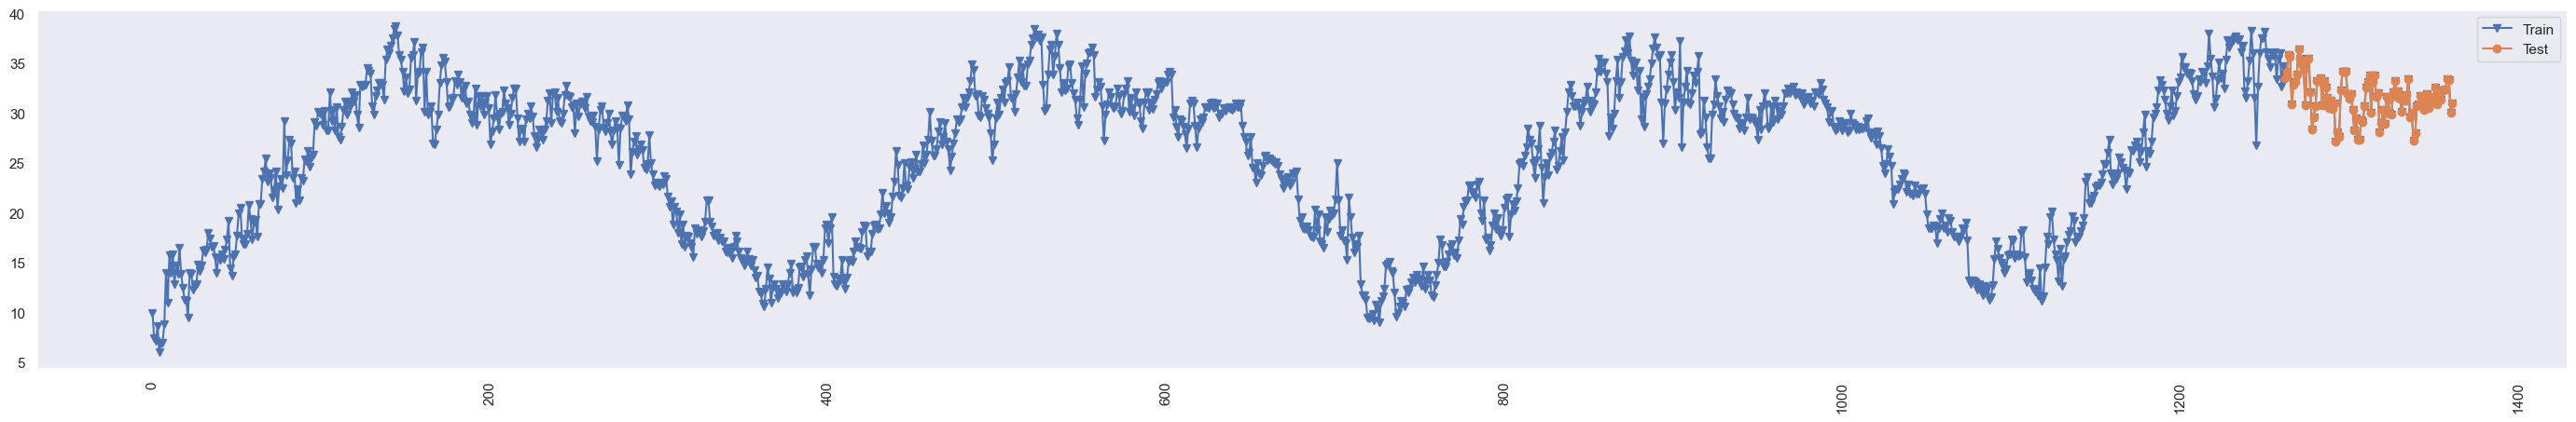

In [312]:
train=df_climate_train[:-100]
test=train[-100:]

plt.figure(figsize=(35,5))
plt.grid()
plt.plot(train['meantemp'], marker='v', label='Train')
plt.plot( test['meantemp'], marker='o', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=4.81 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=5457.135, Time=0.40 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=5182.315, Time=0.46 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=2.19 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=5181.505, Time=0.22 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=5182.246, Time=0.91 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=5184.182, Time=0.88 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=5065.073, Time=0.61 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=5067.061, Time=0.69 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=5067.040, Time=0.89 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=5068.947, Time=1.20 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=4918.194, Time=0.35 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=4777.545, Time=2.45 sec
 ARIMA(3,2,0)(2,0,0)[4]             : AIC=4690.470, Time=5.05 sec
 ARIMA(3,2,0)(2,0,1)[4]             : AIC=i

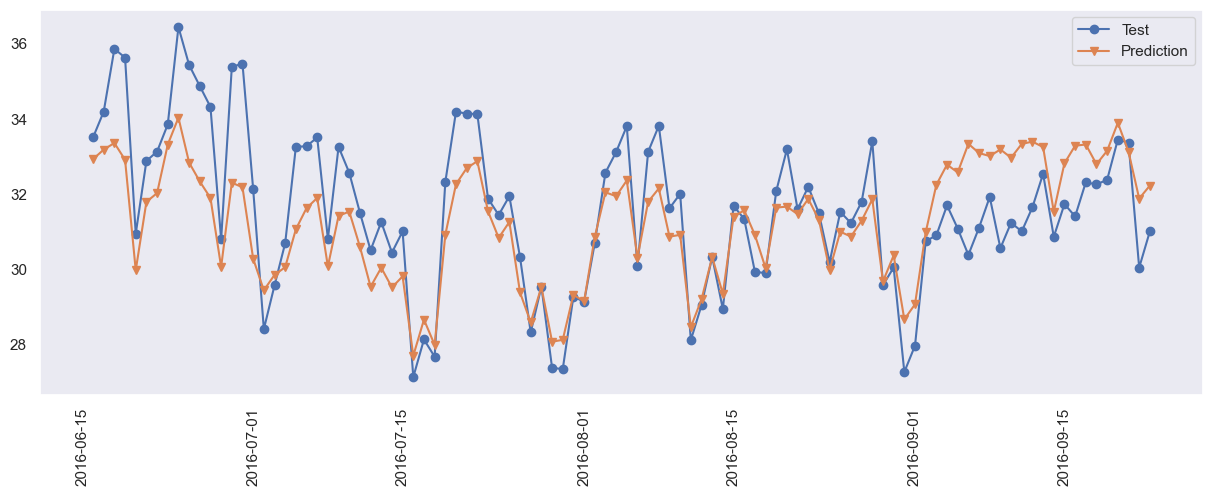

Mean Absolute Percentage Error 0.03290663010609338
Mean Squared Error 1.7380502560702351
RMSE 1.3183513401480786
AIC values 4690.46988914943


In [316]:
# Model Evaluation 

# Fit a simple auto_arima model
arima = pm.auto_arima(train['meantemp'],X=train[['humidity', 'wind_speed','meanpressure']], d=2,error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=500,m=4,stationary=False,test='adf')

# Print out summary information on the fit
print(arima.summary())
print(arima.params)



pred=arima.predict(n_periods=100, X=test[['humidity', 'wind_speed','meanpressure']], alpha=0.05)
pred

plt.figure(figsize=(15,5))
plt.grid()
#plt.plot(data['Period'][:-10], train['GDP_GROWTH'], marker='o', label='Train')
plt.plot(train['date'][-100:],test['meantemp'], marker='o', label='Test')
plt.plot(train['date'][-100:],pred, marker='v', label='Prediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()
print("="*50)
print("="*50)
mape=mean_absolute_percentage_error(test['meantemp'], pred)
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error(test['meantemp'], pred)
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("="*50)
print("AIC values {}".format(arima.aic()))

# <font color='green' style='font-size: 30px;'> 4.3) Random Forest </font>
<hr style='border: 2px solid green;'>

> 1. Não Requer premissas

# <font color='green' style='font-size: 30px;'> 4.4) LightGBM </font>
<hr style='border: 2px solid green;'>

> 1. Não Requer premissas